# UMAP Analysis

Based on the following [UMAP library](https://umap-learn.readthedocs.io).

In [1]:
# Preambe
%matplotlib inline
import sys
import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot
import warnings
import plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from mpl_toolkits.mplot3d import Axes3D
py.offline.init_notebook_mode(connected=True)
warnings.filterwarnings('ignore')

In [2]:
import umap

Bring in all the data and the vectors.

In [3]:
%store -r model_words_neg # List of negative model words (non suicide)

no stored variable # List of negative model words


In [5]:
%store -r model_words # List of positive model words (suicide)

no stored variable # List of positive model words


In [6]:
len(model_words)

548

In [7]:
len(model_words_neg)

581

In [8]:
def words_to_vectors(model, words):
    "Create the word to vector mapping"
    safe_words = []
    not_safe_words = []
    vectors = []
    
    # Figure out which words are in the vocab:
    all_words = sorted(words)
    for word in all_words:
        try:
            vectors.append(model[word])
            safe_words.append(word)
        except:
            not_safe_words.append(word)
    
    return safe_words, vectors

Load in the Stanford model:

In [9]:
def load_stanford_model(filename, binary=False):
    "Load the vectors from the given filename"
    return KeyedVectors.load_word2vec_format(filename, binary=binary)

In [10]:
stanford_model = load_stanford_model(filename = 'data/glove.6B.50d.w2v')

In [11]:
stanford_model

In [12]:
words, vectors = words_to_vectors(stanford_model, model_words)

In [13]:
words_neg, vectors_neg = words_to_vectors(stanford_model, model_words_neg)

In [14]:
len(words)

517

In [15]:
len(words_neg)

537

### UMAP

In [16]:
merged_words = words + words_neg
merged_vectors = vectors + vectors_neg

In [62]:
fit = umap.UMAP()

In [63]:
f1 = fit.fit_transform(merged_vectors)
f1

array([[ 0.39116433, -3.0549004 ],
       [-3.055104  ,  1.5953261 ],
       [ 3.3237169 , -0.61034054],
       ...,
       [ 2.6382408 ,  2.9687428 ],
       [ 1.3533863 ,  1.0424311 ],
       [ 4.3622026 ,  3.238255  ]], dtype=float32)

## Hyperparameters

UMAP has several hyper parameters we can configure:

   - n_neighbors
   - min_dist
   - n_components
   - metric

We'll write a sccript to loop through various parameters and produce multiple graphs.

In [64]:
def draw_umap(data, n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data);
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)))
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1])
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], s=100)
    plt.title(title, fontsize=18)

In [65]:
sns.set(style='white', context='poster', rc={'figure.figsize':(14,10)})

#### n_neighbors

Read about this hyperparameter [here](https://umap-learn.readthedocs.io/en/latest/parameters.html#n-neighbors)

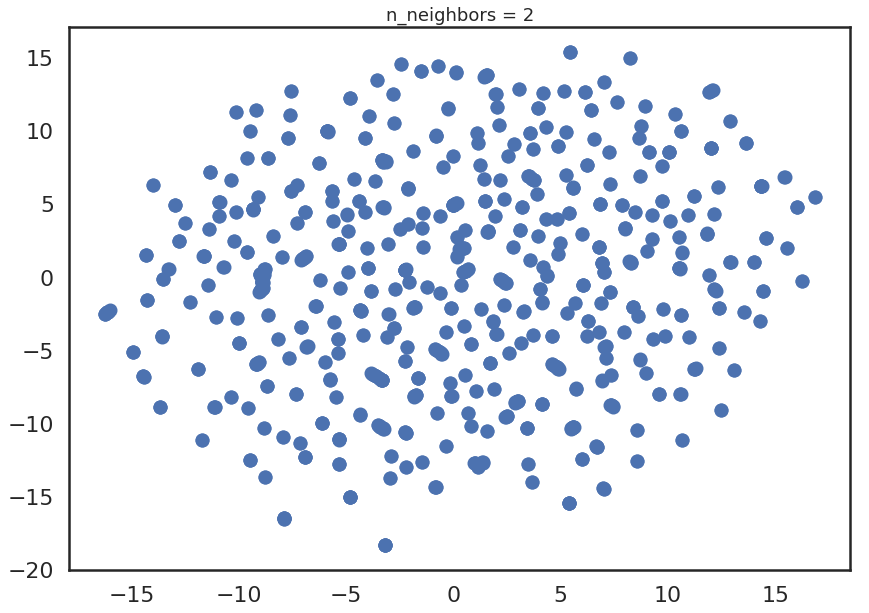

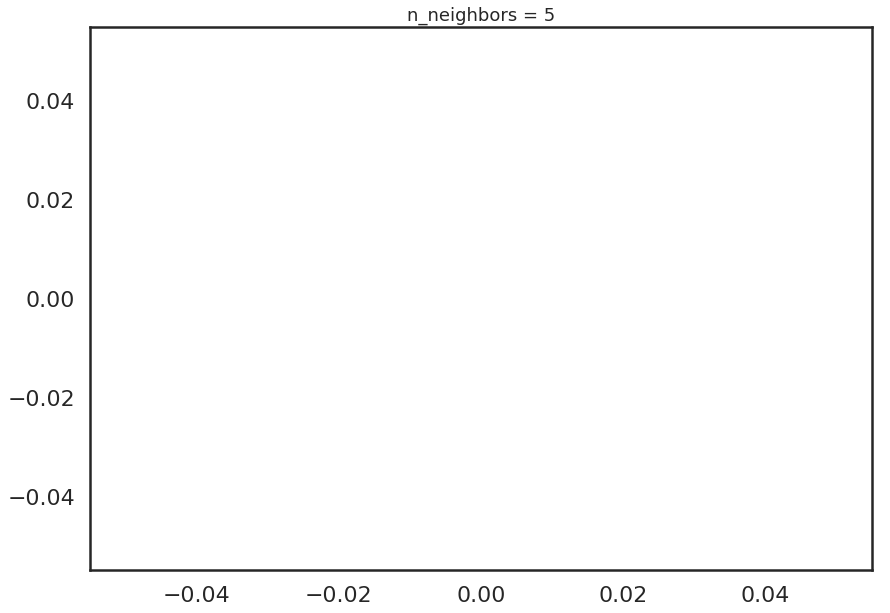

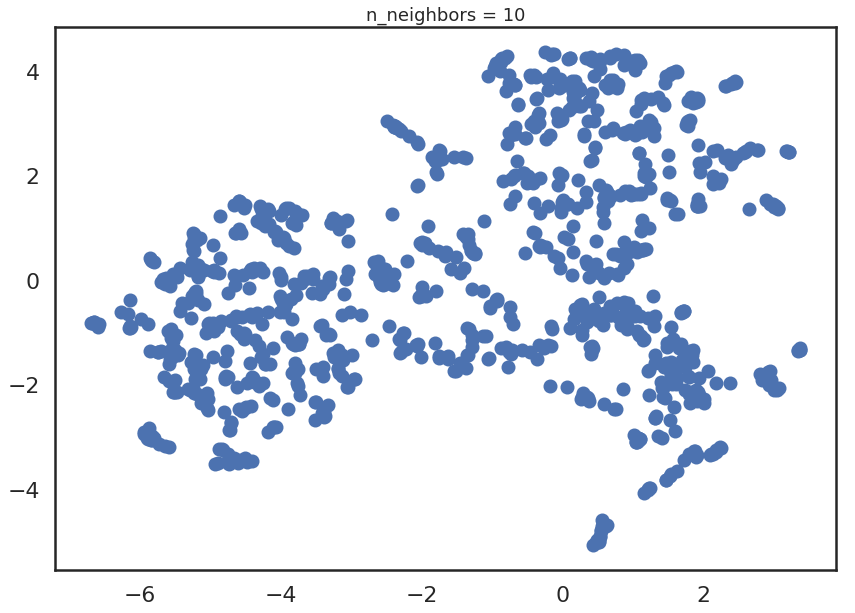

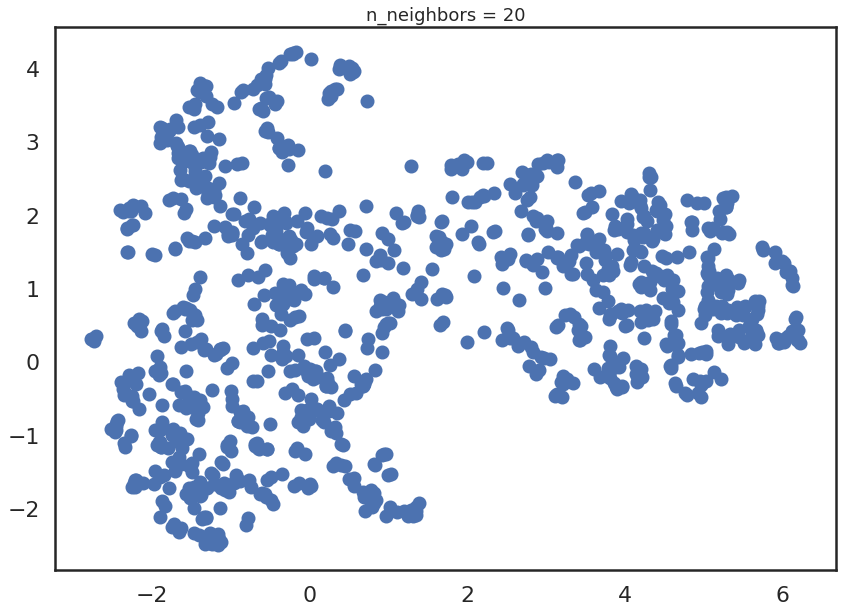

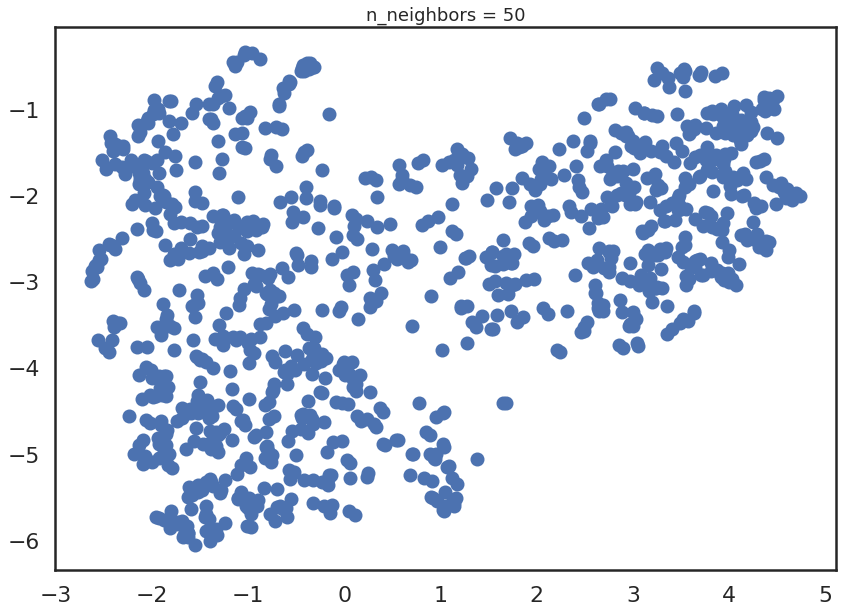

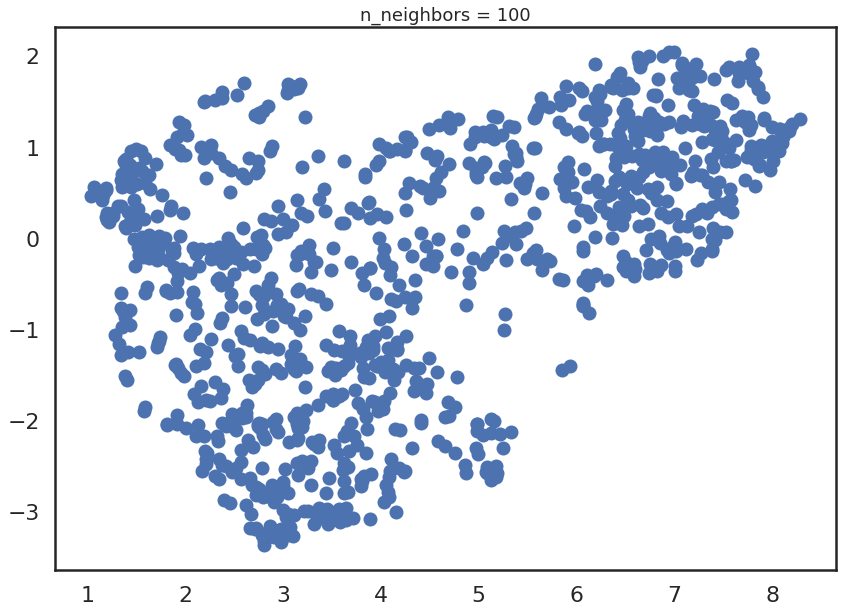

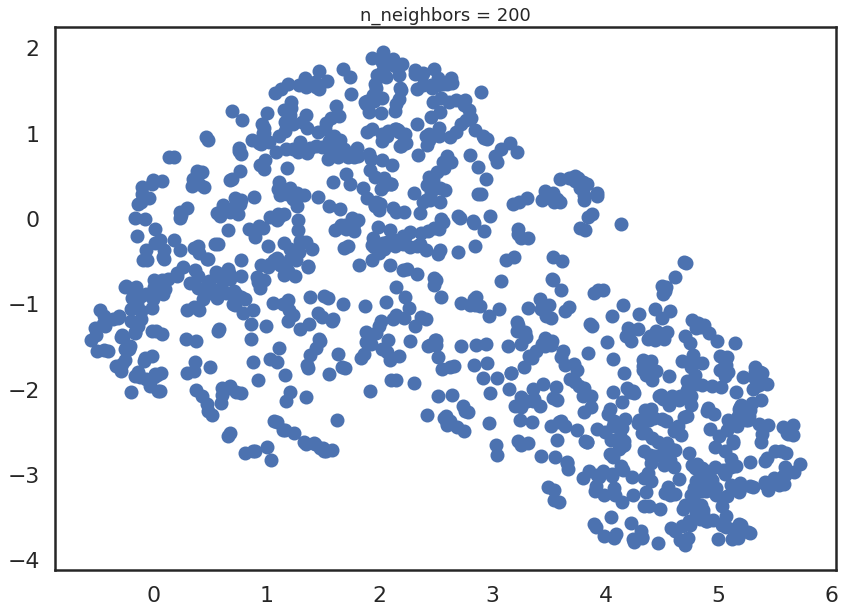

In [66]:
for n in (2, 5, 10, 20, 50, 100, 200):
    draw_umap(data=merged_vectors, n_neighbors=n, title='n_neighbors = {}'.format(n))

#### min_dist

Read about this hyper parameter [here](https://umap-learn.readthedocs.io/en/latest/parameters.html#n-neighbors)

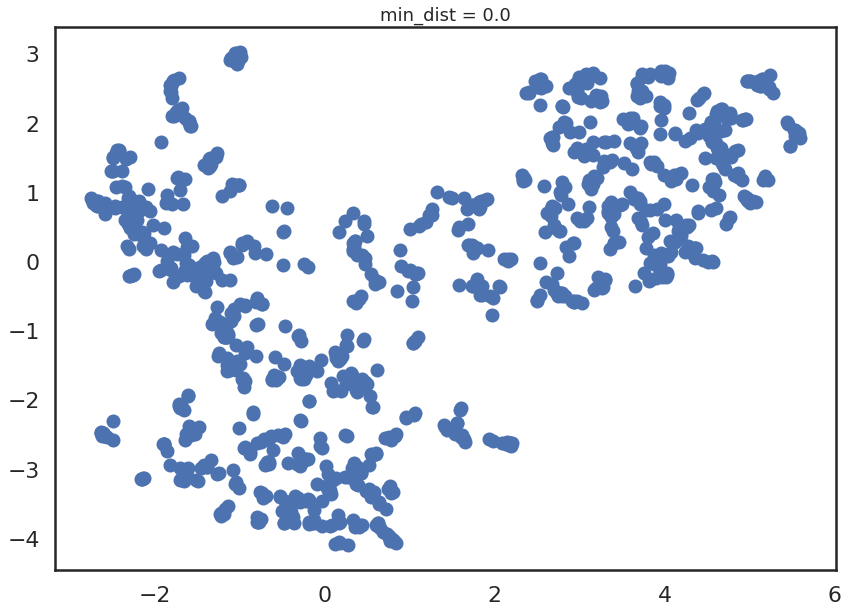

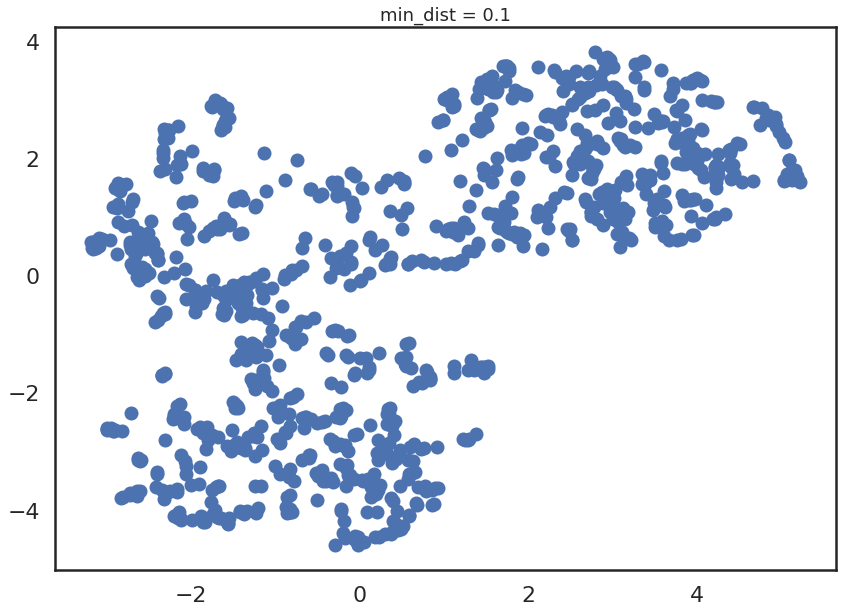

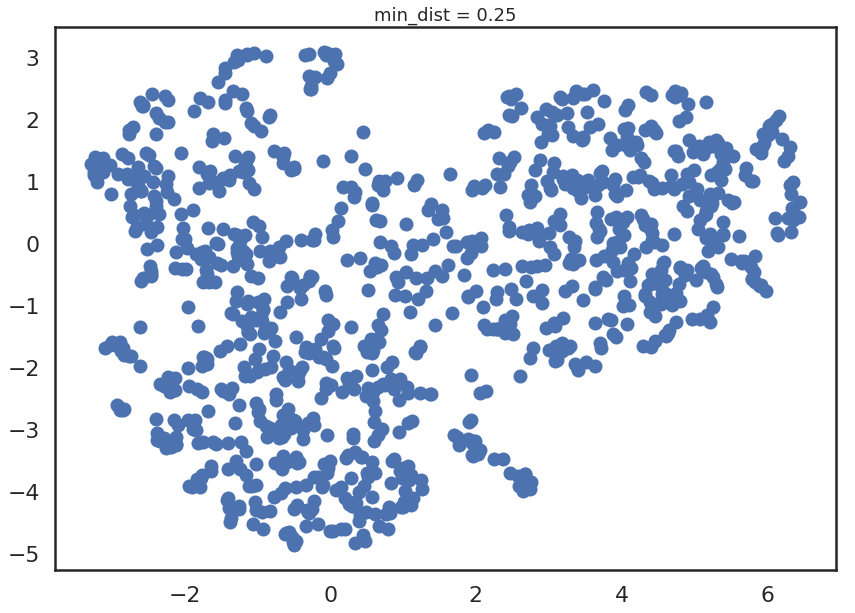

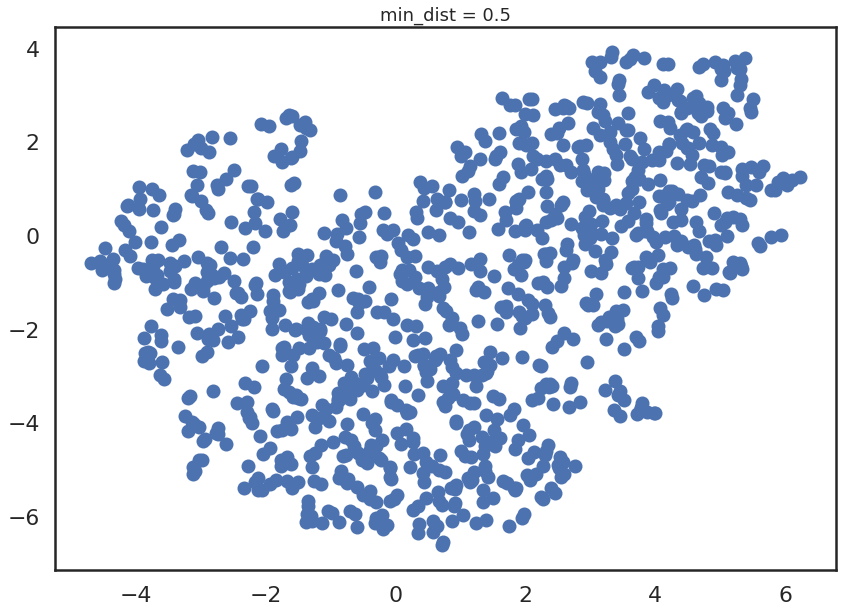

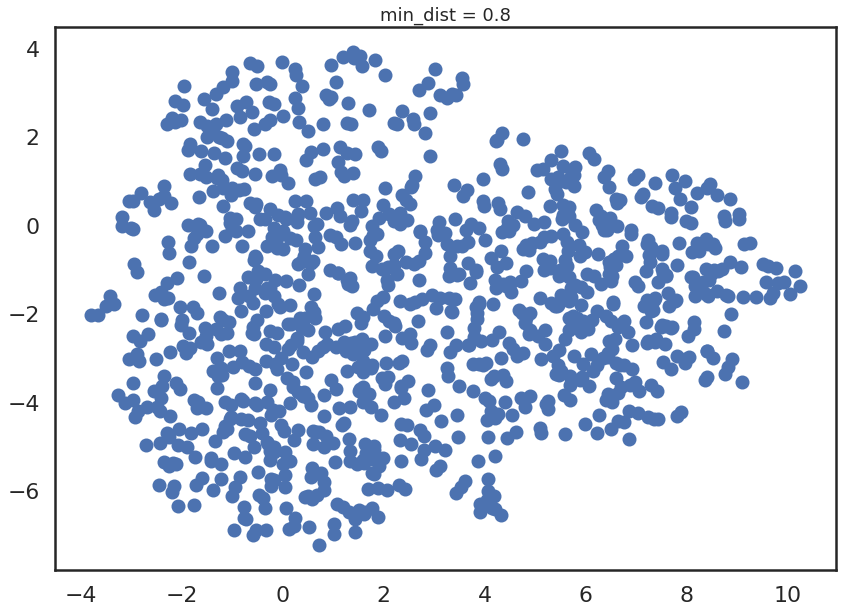

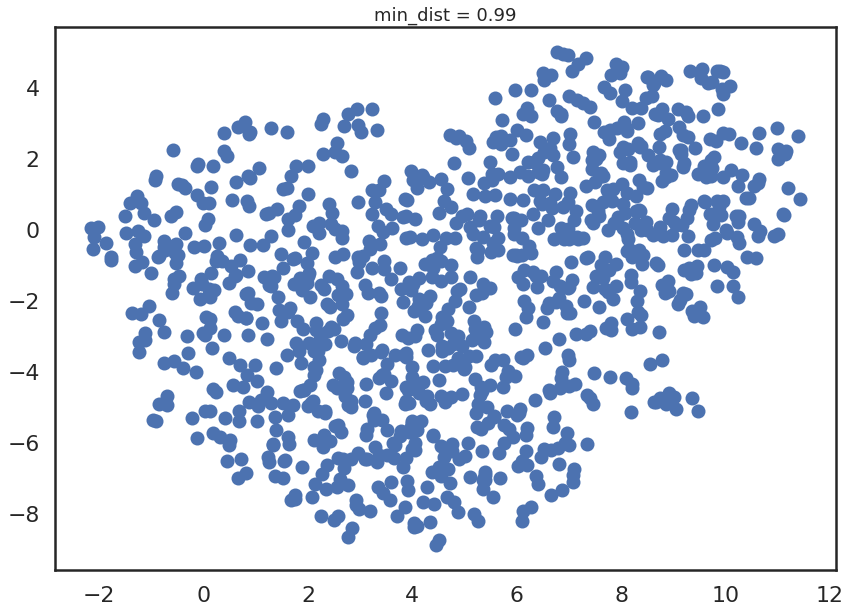

In [67]:
for d in (0.0, 0.1, 0.25, 0.5, 0.8, 0.99):
    draw_umap(data=merged_vectors, min_dist=d, title='min_dist = {}'.format(d))

#### n_components

Read about the hyper-parameter [here](https://umap-learn.readthedocs.io/en/latest/parameters.html#n-components). It basically controls the dimension to which UMAP does a reduction.

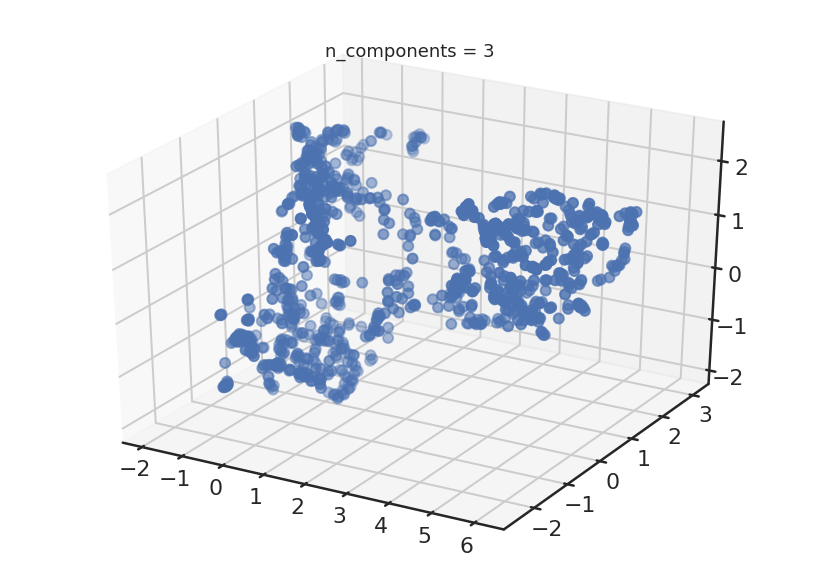

In [68]:
draw_umap(data=merged_vectors, n_components=3, title='n_components = 3')

#### "The best one"

Out of the above one, I have chosen one that looks like a good combination of the hyper parameters.

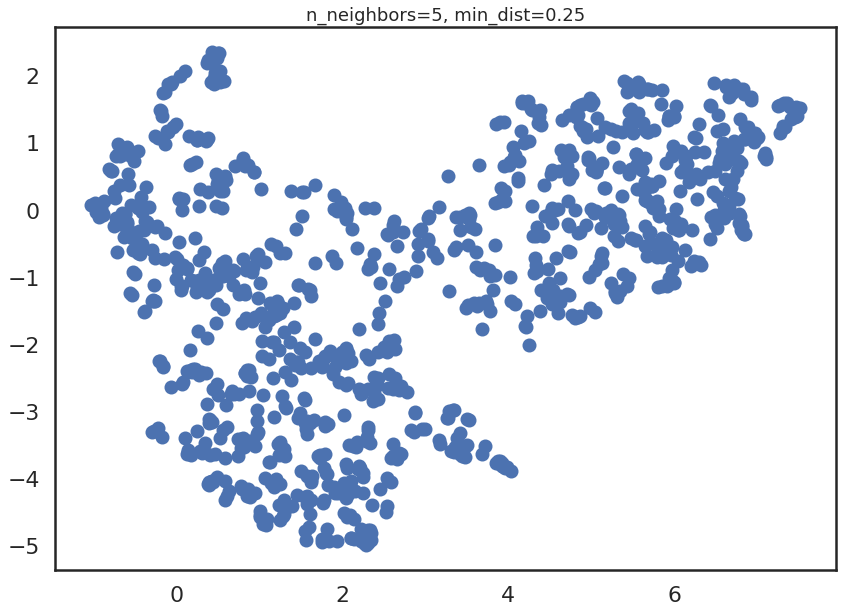

In [69]:
draw_umap(data=merged_vectors, n_neighbors=20, min_dist=0.1, title='n_neighbors=5, min_dist=0.25')

##### Interactive plot

In [58]:
def interactive_plot(data, save=False, show_labels=False):
    "Creates the t-SNE interactive plot"
    pos, neg, both, points = [], [], [], []
    
    # Should we show markers / markers & text
    if show_labels:
        mode = "markers+text"
    else:
        mode = "markers"

    # Loop through and figure out what is in pos/neg/both
    for i, w in enumerate(merged_words):
        item = [w, data[i]]
        if w in words and w in words_neg:
            both.append(item)
        elif w in words_neg:
            neg.append(item)
        elif w in words:
            pos.append(item)
            
    print("Positive class: {}".format(len(pos)))
    print("Negative class: {}".format(len(neg)))
    print("Both classes: {}".format(len(both)))
    
    print()
    
    # Create a trace for the data
    positive= go.Scatter(
        x= [item[1][0] for item in pos],
        y= [item[1][1] for item in pos],
        mode= mode,
        marker=dict(color = "red"),
        text= [item[0] for item in pos],
        textposition='top center',
        name='Positive')
    points.append(positive)
    
    negative= go.Scatter(
        x= [item[1][0] for item in neg],
        y= [item[1][1] for item in neg],
        mode= mode,
        marker=dict(color = "blue"),
        text= [item[0] for item in neg],
        textposition='top center',
        name='Negative')
    points.append(negative)
    
    both= go.Scatter(
        x= [item[1][0] for item in both],
        y= [item[1][1] for item in pos],
        mode= mode,
        marker=dict(color = "orange"),
        text= [item[0] for item in both],
        textposition='top center',
        name='Both')
    points.append(both)
    
    # Set the title
    title = "UMAP for Embedded Vectors for {} words".format(len(merged_words))
    
    # Save the html file 
    if save:
        py.offline.plot({
            "data": points, 
            "layout": go.Layout(title=title, 
                            showlegend=True)
        }, auto_open=False, filename="output/umap-interactive-plot.html")
    
    
    py.offline.iplot({
        "data": points, 
        "layout": go.Layout(title=title, 
                            showlegend=True)
    })

In [19]:
print(len(merged_vectors), len(merged_words))

1054 1054


In [21]:
fit = umap.UMAP(
        n_neighbors=5,
        min_dist=0.25,
        n_components=2,
    )
v = fit.fit_transform(merged_vectors);

In [61]:
interactive_plot(data=v, show_labels=True, save=True)

Positive class: 242
Negative class: 262
Both classes: 550

